# Wikipedia Notable Life Expectancies

# [Notebook 5 of : Data Cleaning](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_06_23.ipynb)

## Context

The


## Objective

The

### Data Dictionary

- Feature: Description

## Importing Necessary Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean3.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean3", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 24 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,,None,volleyball player,Olympic champion coach,None,None,None,None,None,None,None,None,69.0,None,Russia,None,1980
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,engineer,member of the Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None,"China, People's Republic of",None,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
46980,23,Fran Crippen,", 26, American swimmer, heart attack.",https://en.wikipedia.org/wiki/Fran_Crippen,8,2010,October,None,None,swimmer,heart attack,None,None,None,None,None,None,None,None,26.0,None,United States of America,None,None
85972,21,Andrew Karpati Kennedy,", 85, Hungarian-born British author and literary critic.",https://en.wikipedia.org/wiki/Andrew_Karpati_Kennedy,15,2016,December,None,None,author literary critic,None,None,None,None,None,None,None,None,None,85.0,None,Hungary,United Kingdom of Great Britain and Northern Ireland,None
29330,14,Shelley Winters,", 85, American actress , heart failure.",https://en.wikipedia.org/wiki/Shelley_Winters,43,2006,January,"Oscar, , , winner ,",None,actress,heart failure,None,None,None,None,None,None,None,None,85.0,None,United States of America,None,"Oscar, 1960, 1966, winner ,"
109630,12,Wolfgang Hofmann,", 78, German judoka, Olympic silver medalist .",https://en.wikipedia.org/wiki/Wolfgang_Hofmann,1,2020,March,,None,judoka,Olympic silver medalist,None,None,None,None,None,None,None,None,78.0,None,Germany,None,1964
119682,20,Wai Yan Tun,", 16, Burmese protester, shot.",https://en.wikipedia.org/wiki/Wai_Yan_Tun,7,2021,February,None,None,protester,shot,None,None,None,None,None,None,None,None,16.0,None,Burma,None,None


<IPython.core.display.Javascript object>

### Checking Data Types, Duplicates, and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   day                132652 non-null  object 
 1   name               132652 non-null  object 
 2   info               132652 non-null  object 
 3   link               132652 non-null  object 
 4   num_references     132652 non-null  object 
 5   year               132652 non-null  int64  
 6   month              132652 non-null  object 
 7   info_parenth       49830 non-null   object 
 8   info_1             35 non-null      object 
 9   info_2             132604 non-null  object 
 10  info_3             62571 non-null   object 
 11  info_4             12605 non-null   object 
 12  info_5             1497 non-null    object 
 13  info_6             216 non-null     object 
 14  info_7             31 non-null      object 
 15  info_8             6 non-null       object 
 16  in

<IPython.core.display.Javascript object>

#### Observations:
- Due to the diversity of entries for `known_for`, we may need to prioritize entries for the extraction of this feature.
- To do so, we will proceed with typecasting num_references as integer, so we can determine which entries have more references.
- We will also make a copy of the `info_parenth` column, as we will alter that column and the information it contains is no longer present in the original `info` column.

#### Typecasting `num_references` as Integer

In [6]:
# Typecasting num_references as int64
df.loc[:, "num_references"] = df.loc[:, "num_references"].astype("int64")

<IPython.core.display.Javascript object>

#### Loading `nation_map` from Pickle File to Dictionary nation_map

In [7]:
# Load the nation_map
with open("nation_map.pkl", "rb") as f:
    nation_map = pickle.load(f)

<IPython.core.display.Javascript object>

#### Loading `other_species` list from other_species.csv

In [8]:
# Loading other_species list
other_species_df = pd.read_csv("other_species.csv")
other_species = other_species_df["species"].tolist()
other_species = list(
    set(other_species)
)  # To avoid searching duplicates as we have been adding back to same csv file

<IPython.core.display.Javascript object>

### `num_references`

In [9]:
df["num_references"].describe()

count    132652.000000
mean          9.790406
std          19.436805
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         837.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

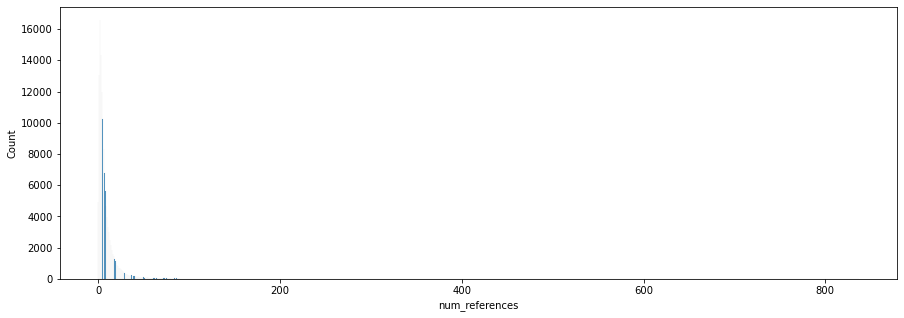

<IPython.core.display.Javascript object>

In [10]:
# Histplot of num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` is highly right skewed.
- We will verify some verifying of links to make sure the pages are for individuals.

In [11]:
# Example of verifying links (repeated in groups of 100 until num_references <100)
df.sort_values(by="num_references", ascending=False)[:10]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
36579,19,Bill Andress,", 83, American baseball umpire.",https://en.wikipedia.org/wiki/Bill_Andress,837,2008,May,None,None,baseball umpire,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None
11356,14,Frank Sinatra,", 82, American singer , heart attack.",https://en.wikipedia.org/wiki/Frank_Sinatra,660,1998,May,"""My Way"", ""That Life"" actor Oscar, winner",None,singer,heart attack,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,"""My Way"", ""That Life"" actor Oscar, 1954 winner"
35265,17,Bobby Fischer,", 64, American chess grandmaster, world champion , kidney failure.",https://en.wikipedia.org/wiki/Bobby_Fischer,631,2008,January,,None,chess grandmaster,world champion,kidney failure,None,None,None,None,None,None,None,64.0,None,United States of America,None,1972 1975
26014,11,Keith Miller,", 84, Australian Test cricketer, Australian rules footballer, fighter pilot and journalist.",https://en.wikipedia.org/wiki/Keith_Miller,586,2004,October,None,None,Test cricketer,rules footballer,fighter pilot journalist,None,None,None,None,None,None,None,84.0,None,Australia,Australia,None
35003,28,Benazir Bhutto,", 54, Pakistani opposition leader and former prime minister , assassinated.",https://en.wikipedia.org/wiki/Benazir_Bhutto,554,2007,December,",",None,opposition leader former prime minister,assassinated,None,None,None,None,None,None,None,None,54.0,None,Pakistan,None,"1988 1990, 1993 1996"
85511,25,Fidel Castro,", 90, Cuban politician, Prime Minister .",https://en.wikipedia.org/wiki/Fidel_Castro,531,2016,November,", President",None,politician,Prime Minister,None,None,None,None,None,None,None,None,90.0,None,Cuba,None,"1959 1976, President 1976 2008"
60287,5,Hugo Chávez,", 58, Venezuelan politician and military officer, President , heart attack.",https://en.wikipedia.org/wiki/Hugo_Ch%C3%A1vez,529,2013,March,since,None,politician military officer,President,heart attack,None,None,None,None,None,None,None,58.0,None,Venezuela,None,since 1999
97905,25,John McCain,", 81, American politician and Navy officer, member of the U.S. Senate , glioblastoma.",https://en.wikipedia.org/wiki/John_McCain,528,2018,August,since House of Representatives,None,politician Navy officer,member of the Senate,glioblastoma,None,None,None,None,None,None,None,81.0,None,United States of America,None,since 1987 House of Representatives 1983 1987
51541,20,Muammar Gaddafi,", 69, Libyan leader , shooting.",https://en.wikipedia.org/wiki/Muammar_Gaddafi,519,2011,October,,None,leader,shooting,None,None,None,None,None,None,None,None,69.0,None,Libya,None,1969 2011
105520,6,Robert Mugabe,", 95, Zimbabwean revolutionary and politician, President , cancer.",https://en.wikipedia.org/wiki/Robert_Mugabe,519,2019,September,Prime Minister,None,revolutionary politician,President,cancer,None,None,None,None,None,None,None,95.0,None,Zimbabwe,None,1987 2017 Prime Minister 1980 1987


<IPython.core.display.Javascript object>

#### Observations:
- Some links point to lists, such as the entry with the maximum `num_references` for Bill Andress.
- Also, there are several entries that point to a list of German World War II medal recipiants.
- We will make a list of these links and change their `num_references` values to 1.

In [12]:
# Creating list of links containing "German" with over 20 references
checklist = [
    index
    for index in df.index
    if "German" in df.loc[index, "info"] and df.loc[index, "num_references"] > 20
]
link_list = df.loc[checklist, "link"].tolist()

<IPython.core.display.Javascript object>

In [13]:
# # Code used to go verify links
# print(link_list.pop())

<IPython.core.display.Javascript object>

In [14]:
# List of links that point to pages with lists of individuals
link_is_list = [
    "https://en.wikipedia.org/wiki/Bill_Andress",
    "https://en.wikipedia.org/wiki/Joachim_Boosfeld",
    "https://en.wikipedia.org/wiki/Alfred_Eick",
    "https://en.wikipedia.org/wiki/Gerhard_Fischer_(soldier)",
    "https://en.wikipedia.org/wiki/Arthur_B%C3%BCssecke",
    "https://en.wikipedia.org/wiki/Hans-G%C3%BCnther_Lange",
    "https://en.wikipedia.org/wiki/Waldemar_von_Gazen",
    "https://en.wikipedia.org/wiki/Heinz_Angelmaier",
    "https://en.wikipedia.org/wiki/Herbert_Fries",
    "https://en.wikipedia.org/wiki/Friedrich_Carl_(officer)",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Altermann",
    "https://en.wikipedia.org/wiki/Paul_Brasack",
    "https://en.wikipedia.org/wiki/Walther_Gerhold",
    "https://en.wikipedia.org/wiki/Siegfried_Gerstner",
    "https://en.wikipedia.org/wiki/Alois_Schnaubelt",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Wiebe",
    "https://en.wikipedia.org/wiki/Hans-Hermann_Sturm",
    "https://en.wikipedia.org/wiki/Siegfried_Jamrowski",
    "https://en.wikipedia.org/wiki/Franz_Kieslich",
    "https://en.wikipedia.org/wiki/Wilhelm_Lehner",
    "https://en.wikipedia.org/wiki/Fritz_Langanke",
    "https://en.wikipedia.org/wiki/Achim_Wunderlich",
    "https://en.wikipedia.org/wiki/Viktor_Vitali",
    "https://en.wikipedia.org/wiki/Wilhelm_Noller",
    "https://en.wikipedia.org/wiki/Heinrich_Sonne",
    "https://en.wikipedia.org/wiki/Ludwig_Meister",
    "https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer",
    "https://en.wikipedia.org/wiki/Karl_Brommann",
    "https://en.wikipedia.org/wiki/Friedrich_Adrario",
    "https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz",
    "https://en.wikipedia.org/wiki/Hans-Georg_Borck",
    "https://en.wikipedia.org/wiki/Wilhelm_Weidenbr%C3%BCck",
    "https://en.wikipedia.org/wiki/Klaus_Feldt",
    "https://en.wikipedia.org/wiki/Erwin_Bachmann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz)",
    "https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Ba%E2%80%93Bm)",
    "https://en.wikipedia.org/wiki/Family_of_Barack_Obama#Stanley_Armour_Dunham",
]

<IPython.core.display.Javascript object>

#### Changing `num_references` to 1 Where Entry Link Points to a List Page

In [15]:
# Creating list of row indexes with links that point to lists
rows_to_treat = [index for index in df.index if df.loc[index, "link"] in link_is_list]

# Treating num_references for these entries
df.loc[rows_to_treat, "num_references"] = 1

# Checking a sample of rows
df.loc[rows_to_treat, :].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
74883,12,Alfred Eick,", 99, German U-boat commander.",https://en.wikipedia.org/wiki/Alfred_Eick,1,2015,April,None,None,U boat commander,None,None,None,None,None,None,None,None,None,99.0,None,Germany,None,None
49476,8,Hans-Georg Borck,", 89, German military officer.",https://en.wikipedia.org/wiki/Hans-Georg_Borck,1,2011,May,None,None,military officer,None,None,None,None,None,None,None,None,None,89.0,None,Germany,None,None


<IPython.core.display.Javascript object>

#### Observations:
- With those entries treated, and the other top entries verified, let us take another look at the summary statistics and distribution of `num_references`.

In [16]:
# Summary statistics of updated num_references
df["num_references"].describe()

count    132652.000000
mean          9.736016
std          19.066372
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         660.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

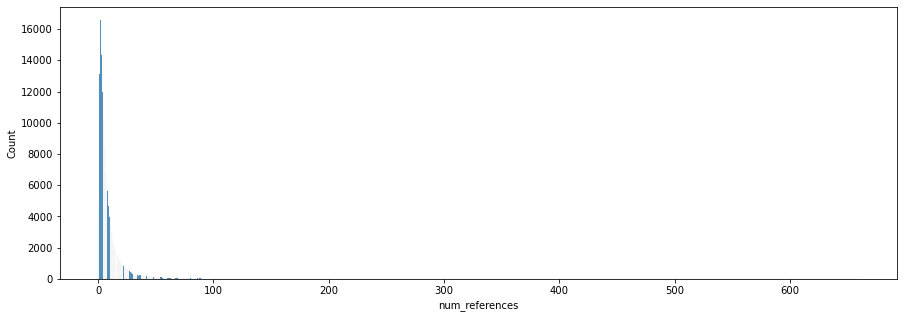

<IPython.core.display.Javascript object>

In [17]:
# Histplot of updated num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` remains highly right skewed.
- 25% of entries have 2 or fewer references, which may be a good cutoff to search for `known_for` values.
- Let us view the log transformation of the feature, both for the full dataset, and for `num_references` > 2.

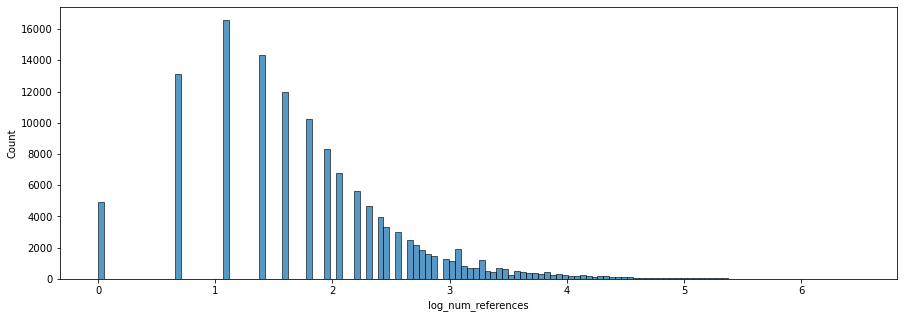

<IPython.core.display.Javascript object>

In [18]:
# Adding column for log_num_references
df["log_num_references"] = np.log(df["num_references"] + 1)

# Histplot of log_num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="log_num_references")
plt.show()

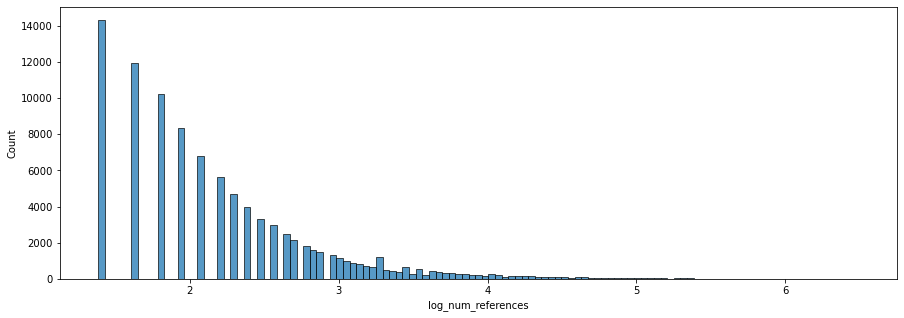

<IPython.core.display.Javascript object>

In [19]:
# Histplot of log_num_references where num_references > 2
plt.figure(figsize=(15, 5))
sns.histplot(data=df[df["num_references"] > 2], x="log_num_references")
plt.show()

#### Observations:
- The distribution is certainly more normalized with the log transformation, but follows a consistent curve for values > 2.
- For this analysis, we will focus on these more noted entries.
- We can keep the full dataset intact at this point, but rely on these entries to create a dictionary for extracting `known_for` values.

## Extracting `known_for` Data
Our goal will be to have some broader categories into which the specific values will fit.  `known_for` is a diverse feature, in that an individual may be known for a long-term role or roles, a specific event, a relationship with another person who is famous, etc.  So, to some extent we will see what we find and adapt as we go.

Also, we will abandon searching left to right as an individual may fit more than one category, and in no particular order.  For example, Ronald Reagan, is entered as "American actor and politician".  He is most known as the 40th president of The United States, so if we prioritized the first value, he would fit only into the category containing actor.  At the same time, it may have been his acting career that led to his political career.  Both arenas are relevant, so we will aim to capture all categories for an individual.  Later, when there are duplicate categories for an indivual, we can remove the redundant values.

We will take the following approach:
1. create and check a list of unique values in `info_2` that have a minimum number repeated, sufficient to create sets for each category, but not so exhaustive to be time prohibitive to manually enter.
2. using the pop() method, add each role to it's associated category's set, below.
3. combine the sets for each category into one dictionary.
4. search for the values in the dictionary and extract the category key value to a new column `known_for_1`, `known_for_2`, etc.

In [20]:
# Obtaining values for column and their counts
col_values = df[df["num_references"] > 2]["info_2"].value_counts()

# Creating a list for values that occur more than set number of times
roles_list = [index for index in col_values.index if col_values[index] > 20]

# Checking length of list
print(f"We will examine the top {len(roles_list)} unique values in info_2.")

We will examine the top 488 unique values in info_2.


<IPython.core.display.Javascript object>

In [21]:
# # Using pop to check list items and add to associated dictionary below
# roles_list.pop()

<IPython.core.display.Javascript object>

In [22]:
# Creating lists for each category
politics_govt_law = [
    "retired lawyer Justice Department official known for prosecution of alleged war criminals",
    "prosecutor for war criminals",
    "criminal defense",
    "political scientist",
    "politic",
    "princess",
    "prince",
    "lawyer",
    "attorney",
    "judge",
    "Justice",
    "justice",
    "solicitor",
    "jurist",
    "jury",
    "juror",
    "econom",
    "barrister",
    "conservationis",
    "govern",
    "peer",
    "environmentalis",
    "human rights",
    "civil rights",
    "rights",
    "activist",
    "aristocrat",
    "diploma",
    "public servant",
    "federal",
    "royal",
    "consort",
    "civil servant",
    "ambassador",
    "Ambassador",
]

arts = [
    "gospel",
    "producer",
    "disc jockey",
    "film director",
    "designer",
    "science fiction writer",
    "science fiction author",
    "author",
    "screen",
    "write",
    "bluegrass",
    "musician",
    "drama",
    "novelist",
    "journalist",
    "broadcaster",
    "conductor",
    "composer",
    "rock",
    "guitar",
    "actress",
    "actor",
    "model",
    "poet",
    "playwright",
    "puppet",
    "television director",
    "television",
    "TV",
    "host",
    "sculpt",
    "paint",
    "sing",
    "song",
    "radio",
    "presenter",
    "printmaker",
    "potter",
    "reggae",
    "music producer",
    "art dealer",
    "winemaker",
    "artist",
    "blues",
    "country singer",
    "country music",
    "jazz",
    "piano",
    "pianist",
    "choreograph",
    "translator",
    "film",
    "magic",
    "news",
    "anchor",
    "tenor",
    "comic",
    "book",
    "trombon",
    "voice",
    "critic",
    "bass player",
    "bassist",
    "bassoon",
    "bass guitar",
    "editor",
    "document",
    "opera",
    "tenor",
    "organist",
    "keyboard",
    "manga",
    "playback",
    "folk",
    "balle",
    "personality",
    "model",
    "costume",
    "cellist",
    "cello",
    "lyric",
    "soul",
    "soprano",
    "visual",
    "comed",
    "illustrat",
    "R&B",
    "chef",
    "literary",
    "theatre director",
    "theater director",
    "theatre",
    "theater",
    "saxophon",
    "graphic",
    "character",
    "trumpet",
    "pop ",
    "sportscaster",
    "drum",
    "viol",
    "publish",
    "photo",
    "animat",
    "rapper",
    "cinematograph",
    "cinema",
    "fashion",
    "cartoon",
    "architect",
    "MC",
]
sports = [
    "jockey",
    "martial",
    "sports administrator",
    "sports",
    "basketball",
    "NBA",
    "baseball",
    "MLB",
    "handball",
    "cross country",
    "skier",
    "weightlift",
    "football",
    "gymnast",
    "olymp",
    "paralymp",
    "Paralymp",
    "hockey",
    "speedway",
    "rider",
    "chess",
    "runn",
    "cricket",
    "umpire",
    "track",
    "field",
    "athlet",
    "racecar",
    "driver",
    "wrestl",
    "badminton",
    "bodybuild",
    "racehorse trainer",
    "racing",
    "race car",
    "judo",
    "curl",
    "Baseball",
    "bridge player",
    "long distance",
    "distance",
    "sail",
    "sumo",
    "skate",
    "golf",
    "sprint",
    "tennis",
    "fencer",
    "fencing",
    "referee",
    "motorcycle",
    "rower",
    "rowing",
    "mountain",
    "rugby league",
    "rugby",
    "Rugby",
    "boxer",
    "soccer",
    "swim",
    "hurl",
    "cycl",
    "Olymp",
    "general manager",
]
sciences = [
    "game designer",
    "theoretical physicist",
    "molecular",
    "biolog",
    "doctor",
    "psycholog",
    "paleontolog",
    "neurologist",
    "pathologist",
    "psychoanalys",
    "organic chemist",
    "biochem",
    "chemist",
    "aeronautic",
    "engineer",
    "pharmacolog",
    "geophysi",
    "virolo",
    "neurosurg",
    "entomolog",
    "pediatric",
    "cardiolog",
    "physician",
    "nurs",
    "immunolog",
    "meteorolog",
    "ornitholog",
    "medical",
    "zoolog",
    "neuroscientist",
    "geograph",
    "statistic",
    "inventor",
    "genetic",
    "astrophysic",
    "surgeon",
    "geolog",
    "psychiatr",
    "botan",
    "anthropol",
    "astron",
    "archaeolog",
    "computer scien",
    "psycholog",
    "physicist",
    "mathematic",
]

business = [
    "advertising executive",
    "executive",
    "financier",
    "real estate developer",
    "real estate",
    "mogul",
    "restaurant",
    "businesswoman",
    "businessman",
    "business",
    "trade unionist",
    "unionist",
    "industrialist",
    "banker",
    "banking",
    "entrepreneur",
]
academia_humanities = [
    "academic administrator",
    "legal scholar",
    "literary scholar",
    "educat",
    "academ",
    "schol",
    "historian",
    "teacher",
    "philolog",
    "librar",
    "professor",
    "Professor",
    "musicologist",
    "linguist",
    "sociolog",
    "philosoph",
]
law_enf_military_operator = [
    "police officer",
    "police",
    "military officer",
    "officer",
    "air force",
    "Air Force",
    "Navy",
    "navy",
    "naval",
    "admiral",
    "Admiral",
    "marshal",
    "general",
    "lieutenant",
    "veteran",
    "Veteran",
    "intelligence",
    "Army",
    "army",
    "major",
    "militant",
    "pilot",
    "aviat",
    "informant",
    "soldier",
    "CIA",
    "IRA",
    "Marine",
    "marine",
]
spiritual = [
    "prelate",
    "pastor",
    "Buddh",
    "monk",
    "buddh",
    "Jesuit",
    "priest",
    "Episcopal",
    "Anglican",
    "bishop",
    "Bishop",
    "Islamic scholar",
    "religious leader",
    "Catholic",
    "Baptist",
    "evangel",
    "rabbi",
    "Rabbi",
    "cardinal",
    "theolog",
    "Jewish",
]
social = ["social worker", "socialite", "philanthrop"]
# 'terrorist' will need separate treatment
crime = [
    "war criminal",
    "criminal",
    "murderer",
    "mobster",
    "serial killer",
    "convict",
]
event_record_other = [
    "student",
    "survivor",
    "supercentenarian",
]
other_species = other_species + ["Tree", "cocker spaniel"]

<IPython.core.display.Javascript object>

In [23]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "scientist" in df.loc[index, "info"]], :]

<IPython.core.display.Javascript object>

#### Observations:
- We have a good start on `known_for_1` values for which to search.  Some other roles that have been observed previously we have added to the list also.
- Note that roles such as sportswriter and sports broadcaster, though associated with sports, are also included in arts, to align with the underlying nature of the work itself.
- Let us combine them into one dictionary, taking care to put `arts` before `sports`, so that "disc jockey" comes before "jockey".
- We will also include an other_species category here, again putting it last so that trainer and breeder in sports, come before racehorse in other_species.
- Then, we can proceed to extract the category to a new column, `known_for_1`.

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [24]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "social": set(social),
    "spiritual": set(spiritual),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
}

<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_1` Column from `info_1`

In [25]:
# Initializing known_for_1 column
df["known_for_1"] = ""

<IPython.core.display.Javascript object>

In [26]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 24 values in extract_to column.
CPU times: total: 2.66 s
Wall time: 2.64 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1
21865,23,Roberto Matta,", 91 Chilean artist.",https://en.wikipedia.org/wiki/Roberto_Matta,7,2002,November,None,,None,None,None,None,None,None,None,None,None,None,91.0,None,Chile,None,None,2.079442,arts
103467,26,Edmund Seger,", 82 German Olympic wrestler.",https://en.wikipedia.org/wiki/Edmund_Seger,2,2019,May,None,ic wrestler,None,None,None,None,None,None,None,None,None,None,82.0,None,Germany,None,None,1.098612,sports


<IPython.core.display.Javascript object>

#### Observations:
- Once again, the `info_1` column has provided a small sample on which to test our code, which appears to be working.
- We can move on to extracting additional `known_for` values in `info_1` to `known_for_2`.
- Sir Robin Brook is a good example of an individual who would have 3 categories with our approach--business, business, and sports.  So, we will have enough `known_for` columns to extract all values for all entries.  Removing these values has the added benefit of simplifying the columns if we choose to search for `cause_of_death`.

#### Extracting Category to `known_for_2` Column from `info_1`

In [27]:
# Initializing known_for_2 column
df["known_for_2"] = ""

<IPython.core.display.Javascript object>

In [28]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df['known_for_1']!= '') & (df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 9 values in extract_to column.
CPU times: total: 4.64 s
Wall time: 4.65 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2
21050,19,Frank Taylor,", 81. English sports journalist.",https://en.wikipedia.org/wiki/Frank_Taylor_(journalist),3,2002,July,None,,None,None,None,None,None,None,None,None,None,None,81.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.386294,arts,sports
59485,24,Kristján Jóhannsson,"83, Icelandic Olympic athlete.",https://en.wikipedia.org/wiki/Kristj%C3%A1n_J%C3%B3hannsson_(athlete),2,2013,January,None,ic e,None,None,None,None,None,None,None,None,None,None,83.0,None,Iceland,None,None,1.098612,sports,sports


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_3` Column from `info_1`

In [29]:
# Initializing known_for_2 column
df["known_for_3"] = ""

<IPython.core.display.Javascript object>

In [30]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df['known_for_2']!= '') & (df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')

There are 0 values in extract_to column.
CPU times: total: 4.75 s
Wall time: 4.74 s


<IPython.core.display.Javascript object>

In [31]:
# Checking remaining unique values in info_1
df["info_1"].value_counts()

                       6
ian                    2
r                      2
early                  2
ic                     2
ic er                  2
er                     1
choral                 1
college  coach         1
player                 1
ic or                  1
ic mer                 1
ic e                   1
common chimpanzee      1
professional er        1
materials scientist    1
automotive             1
Jr                     1
aka                    1
Jules Engel            1
leader                 1
King of                1
social ist             1
gridiron  player       1
Tree of the Year       1
Name: info_1, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We can update our dictionary and do another iteration on `info_1`.
- For now, we will keep the `other_specis` list off to the side.

In [32]:
# Updating category lists and known_for_dict
arts = arts + ["choral"]
other_species = other_species + ["chimpanzee", "Tree"]
sciences = sciences + ["materials scientist"]
politics_govt_law = politics_govt_law + ["King"]

# Combining separate lists as sets into one dictionary
known_for_dict = {
    "social": set(social),
    "spiritual": set(spiritual),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
}

<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_1` Column from `info_1` with Updated `known_for_dict`

In [33]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 26 values in extract_to column.
CPU times: total: 2.73 s
Wall time: 2.74 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3
11825,23,Manuel Mejía Vallejo,", 75 Colombian writer.",https://en.wikipedia.org/wiki/Manuel_Mej%C3%ADa_Vallejo,2,1998,July,None,r,None,None,None,None,None,None,None,None,None,None,75.0,None,Colombia,None,None,1.098612,arts,,
61945,1,Basil Soper,", British actor, 74–75.",https://en.wikipedia.org/wiki/Basil_Soper,0,2013,June,None,,None,None,None,None,None,None,None,None,None,None,74.5,None,United Kingdom of Great Britain and Northern Ireland,None,None,0.000000,arts,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_2` Column from `info_1` with Updated `known_for_dict`

In [34]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df['known_for_1']!= '') & (df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 10 values in extract_to column.
CPU times: total: 4.66 s
Wall time: 4.66 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3
66902,26,Bill Roetzheim,", 85. American Olympic gymnast.",https://en.wikipedia.org/wiki/Bill_Roetzheim,16,2014,February,None,ic,None,None,None,None,None,None,None,None,None,None,85.0,None,United States of America,None,None,2.833213,sports,sports,
103467,26,Edmund Seger,", 82 German Olympic wrestler.",https://en.wikipedia.org/wiki/Edmund_Seger,2,2019,May,None,ic er,None,None,None,None,None,None,None,None,None,None,82.0,None,Germany,None,None,1.098612,sports,sports,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_3` Column from `info_1` with Updated `known_for_dict`

In [35]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df['known_for_2']!= '') & (df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')

There are 0 values in extract_to column.
CPU times: total: 4.64 s
Wall time: 4.64 s


<IPython.core.display.Javascript object>

#### Observations:
- We have extracted all of the `known_for` information present in `info_1`.
- It is time to proceed with extracting the same from the remaining numbered `info_` columns.
- For now, we will wait to include `info_parenth` as the column may contain extraneous information that could generate errors.  Later, for missing `known_for_1` values we can search it.

#### Extracting Category to `known_for_1` Column from Remaining Numbered `info_` Columns

In [36]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 124019 values in extract_to column.
CPU times: total: 3min 49s
Wall time: 3min 49s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3
9287,14,George Pfister,", 78, American baseball player and coach, heart attack.",https://en.wikipedia.org/wiki/George_Pfister,3,1997,August,None,None,player coach,heart attack,None,None,None,None,None,None,None,None,78.0,None,United States of America,None,None,1.386294,sports,,
38978,4,Giselle Salandy,", 21, Trinidadian boxer, car accident.",https://en.wikipedia.org/wiki/Giselle_Salandy,6,2009,January,None,None,,car accident,None,None,None,None,None,None,None,None,21.0,None,Trinidad and Tobago,None,None,1.945910,sports,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_2` Column from Remaining Numbered `info_` Columns

In [37]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_1']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 45322 values in extract_to column.
CPU times: total: 6min 54s
Wall time: 6min 54s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3
124573,4,Richard T. Farmer,", 86, American businessman and philanthropist, founder and CEO of Cintas .",https://en.wikipedia.org/wiki/Richard_T._Farmer,8,2021,August,,None,ist,founder CEO of Cintas,None,None,None,None,None,None,None,None,86.0,None,United States of America,None,1968 2003,2.197225,social,business,
33059,9,Alfred Chandler,", 88, American economic historian.","https://en.wikipedia.org/wiki/Alfred_D._Chandler,_Jr.",14,2007,May,None,None,ic,None,None,None,None,None,None,None,None,None,88.0,None,United States of America,None,None,2.708050,academia_humanities,politics_govt_law,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_3` Column from Remaining Numbered `info_` Columns

In [38]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_2']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 12919 values in extract_to column.
CPU times: total: 3min 23s
Wall time: 3min 23s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3
118195,10,David Stypka,", 41, Czech singer-songwriter and guitarist, complications from pancreatic cancer and COVID-19.",https://en.wikipedia.org/wiki/David_Stypka,2,2021,January,None,None,er songr ist,complications from pancreatic cancer COVID,None,None,None,None,None,None,None,None,41.0,None,Czech Republic,None,None,1.098612,arts,arts,arts
49761,1,Munir Dar,", 76, Pakistani field hockey player, 1960 Olympic gold medalist.",https://en.wikipedia.org/wiki/Munir_Dar_(field_hockey),12,2011,June,None,None,player,ic gold medalist,None,None,None,None,None,None,None,None,76.0,None,Pakistan,None,None,2.564949,sports,sports,sports


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_4` Column from Remaining Numbered `info_` Columns

In [39]:
# Initializing known_for_4 column
df["known_for_4"] = ""

<IPython.core.display.Javascript object>

In [40]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_4'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_3']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 2538 values in extract_to column.
CPU times: total: 1min 40s
Wall time: 1min 40s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4
68058,26,Lee Marshall,", 64, American radio personality, professional wrestling announcer and voice actor , esophageal cancer.",https://en.wikipedia.org/wiki/Lee_Marshall_(announcer),10,2014,April,Tony The Tiger,None,,professional wrestling announcer,esophageal cancer,None,None,None,None,None,None,None,64.0,None,United States of America,None,Tony The Tiger,2.397895,arts,arts,arts,arts
14501,7,Karrar Hussain,", 88, Pakistani educator, writer and literary critic.",https://en.wikipedia.org/wiki/Karrar_Hussain,5,1999,November,None,None,or,r,None,None,None,None,None,None,None,None,88.0,None,Pakistan,None,None,1.791759,academia_humanities,arts,arts,arts


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_5` Column from Remaining Numbered `info_` Columns

In [41]:
# Initializing known_for_5 column
df["known_for_5"] = ""

<IPython.core.display.Javascript object>

In [42]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_5'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_4']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 488 values in extract_to column.
CPU times: total: 55.9 s
Wall time: 55.8 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5
26348,5,Big Boy Henry,", 83, American blues guitarist, singer and songwriter.",https://en.wikipedia.org/wiki/Big_Boy_Henry,11,2004,December,None,None,ist,er r,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None,2.484907,arts,arts,arts,arts,arts
36736,2,Bo Diddley,", 79, American rock and roll and blues singer, songwriter, and guitarist, heart failure.",https://en.wikipedia.org/wiki/Bo_Diddley,125,2008,June,None,None,roll er,r,and guitarist,heart failure,None,None,None,None,None,None,79.0,None,United States of America,None,None,4.836282,arts,arts,arts,arts,arts


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_6` Column from Remaining Numbered `info_` Columns

In [43]:
# Initializing known_for_6 column
df["known_for_6"] = ""

<IPython.core.display.Javascript object>

In [44]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]  

# Extract to column
extract_to = 'known_for_6'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_5']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 74 values in extract_to column.
CPU times: total: 36.6 s
Wall time: 36.6 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6
36736,2,Bo Diddley,", 79, American rock and roll and blues singer, songwriter, and guitarist, heart failure.",https://en.wikipedia.org/wiki/Bo_Diddley,125,2008,June,None,None,roll er,r,and ist,heart failure,None,None,None,None,None,None,79.0,None,United States of America,None,None,4.836282,arts,arts,arts,arts,arts,arts
37806,20,Duncan Glen,", 75, British poet, literary critic and designer, professor emeritus of visual communication .",https://en.wikipedia.org/wiki/Duncan_Glen,1,2008,September,Nottingham Trent,None,,,emeritus of communication,None,None,None,None,None,None,None,75.0,None,United Kingdom of Great Britain and Northern Ireland,None,Nottingham Trent,0.693147,arts,arts,arts,arts,academia_humanities,arts


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_7` Column from Remaining Numbered `info_` Columns

In [45]:
# Initializing known_for_7 column
df["known_for_7"] = ""

<IPython.core.display.Javascript object>

In [46]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_7'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_6']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 13 values in extract_to column.
CPU times: total: 35.9 s
Wall time: 35.9 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7
21233,16,Edith Addams,", 95, Belgian-American Olympic fencer , costume designer for theater, ballet and film and a theatrical producer.",https://en.wikipedia.org/wiki/Edith_Addams,2,2002,August,,None,ic,for,t a theatrical producer,None,None,None,None,None,None,None,95.0,None,Belgium,United States of America,Belgium,1.098612,sports,sports,arts,arts,arts,arts,arts
29437,1,Ernest Dudley,", 97, British novelist, journalist, screenwriter, actor, radio broadcaster.",https://en.wikipedia.org/wiki/Ernest_Dudley,0,2006,February,None,None,,,r,,,None,None,None,None,None,97.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,0.000000,arts,arts,arts,arts,arts,arts,arts


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_8` Column from Remaining Numbered `info_` Columns

In [47]:
# Initializing known_for_8 column
df["known_for_8"] = ""

<IPython.core.display.Javascript object>

In [48]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_8'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_7']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 4 values in extract_to column.
CPU times: total: 38.8 s
Wall time: 38.8 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8
26024,13,Erik Bye,", 78, Norwegian journalist , radio/TV host, actor, singer/songwriter, cancer.",https://en.wikipedia.org/wiki/Erik_Bye,2,2004,October,"AP, BBC, NRK",None,,,,er r,cancer,None,None,None,None,None,78.0,None,Norway,None,"AP, BBC, NRK",1.098612,arts,arts,arts,arts,arts,arts,arts,arts
12956,1,Barış Manço,", 56, Turkish rock musician, singer, songwriter, composer, actor and show host, heart attack.",https://en.wikipedia.org/wiki/Bar%C4%B1%C5%9F_Man%C3%A7o,7,1999,February,None,None,,er,r,,show,heart attack,None,None,None,None,56.0,None,Turkey,None,None,2.079442,arts,arts,arts,arts,arts,arts,arts,arts


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_9` Column from Remaining Numbered `info_` Columns

In [49]:
# Initializing known_for_9 column
df["known_for_9"] = ""

<IPython.core.display.Javascript object>

In [50]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_9'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_8']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!='']

There are 0 values in extract_to column.
CPU times: total: 35.8 s
Wall time: 35.8 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9


<IPython.core.display.Javascript object>

In [51]:
# Checking the number of missing values in known_for_1 where num_references > 2
print(
    f'There are {len(df[(df["known_for_1"] == "") & (df["num_references"]>2)])} missing values in known_for_1 column for entries with more than 2 references.'
)

There are 6942 missing values in known_for_1 column for entries with more than 2 references.


<IPython.core.display.Javascript object>

#### Observations:
- We have exhuasted our search using the current version of `known_for_dict` and have ~7,000 remaining missing values in `known_for_1` for the entries with more than 2 references.
- Let us examine some of the remaining unique values in `info_2` and update our lists and dictionary.

#### Checking Remaining `info_2` Values

In [52]:
# Obtaining values for column and their counts
col_values = df[(df["known_for_1"] == "") & (df["num_references"] > 2)][
    "info_2"
].value_counts()

# Creating a list for values that occur more than set number of times
roles_list = [index for index in col_values.index if col_values[index] > 2]

<IPython.core.display.Javascript object>

In [53]:
# # Using pop to check list items and add to associated dictionary below
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Updating Category Lists for `known_for_dict`

In [80]:
# Appending category lists
sciences = [
    "administrator of NASA",
    "scientist administrator",
    "zookeeper administrator",
    "zookeeper",
    "computer hacker",
    "atmospheric scientist",
    "optomet",
    "reporter",
    "Pulitzer Prize",
    "anatom",
    "primatolog",
    "geomorpholog",
    "neuroendocrinolog",
    "game developer",
    "limnolog",
    "carcinolog",
    "urolog",
    "gerontolog",
    "hydrolog",
    "software developer",
    "neurophysiolog",
    "embryolog",
    "information scientist",
    "scientist",
    "parasitolo",
    "mammalog",
    "seismolog",
    "volcanolog",
    "sexolog",
    "bacteriolog",
    "etholog",
    "gastroenterolog",
    "video game developer",
    "gynecolog",
    "arachnolog",
    "lichenolog",
    "computer pioneer",
    "computer",
    "crystallograph",
    "ichthyolog",
    "ufolog",
    "toxico",
    "horticultur",
    "archeolog",
    "ecolog",
    "cytolog",
    "first president of Space Agency",
    "scientist former Bell Labs president",
    "president of the Royal College of Psychiatrists",
    "president of the AMA",
    "president of the Horticultural Society",
    "child psychotherapist",
    "haematolog",
    "hematolog",
    "obstetric",
    "gynaecolog",
    "cryptograph",
    "lexicograph",
    "organizational theorist",
    "information theorist",
    "dentist",
    "climatolog",
    "demograph",
    "administrator first leader of NASA",
    "NASA space science administrator a leader in satellite communications",
    "hospital administrator",
    "physiolog",
    "nephrolog",
    "endocrinolog",
    "veterinar",
    "dermatolog",
    "glaciolog",
    "agronom",
    "urban planner",
    "pharmac",
    "naturalist",
    "nutritionist",
    "cancer researcher",
    "oceanograph",
    "oncolog",
    "herpetolog",
    "metallurg",
    "palaeontolog",
    "ophthalmolog",
    "mycolog",
    "paediatric",
    "epidemiolog",
    "criminolog",
    "cosmonaut",
    "psychotherap",
]
politics_govt_law = [
    "military commander",
    "President",
    "computer hacker",
    "elder",
    "herald",
    "landowner",
    "Politic",
    "Member of Parliament",
    "MP",
    "conspiracy theorist",
    "resistance member",
    "parliament",
    "Parliament",
    "communist revolutionary",
    "communist",
    "revolutionary",
    "Communist",
    "Prime Minister of the",
    "Prime Minister",
    "chieftain",
    "first lady",
    "First Lady",
    "foreign minister",
    "loyalist",
    "Arabian prince",
    "prince",
    "detainee",
    "noblewoman",
    "Treasurer",
    "parliamentarian",
    "congresswoman",
    "congressman",
    "congress",
    "Congress",
    "chairwoman",
    "tribal leader",
    "health official",
    "stateswoman",
    "statesman",
    "trans woman pioneer",
    "member of the stolen generations",
    "colonial official",
    "Resistance member",
    "colonial administrator",
    "whistleblower",
    "Conservative",
    "conservative",
    "Democrat",
    "democrat",
    "indigenous leader",
    "legislat",
    "pollster",
    "countess",
    "community leader",
    "statesman",
    "feminis",
    "lobbyist",
    "separatist leader",
    "magistrate",
    "Islamist",
    "commissioner for children",
    "senator",
    "public figure",
    "traditional ruler",
    "courtier",
    "revolution",
    "Governor",
    "Māori leader",
    "nationalist",
    "tribal leader",
    "prosecutor",
    "protester",
    "resistance member",
    "public official",
    "deputy minister",
    "Foreign minister",
    "Cabinet minister",
    "cabinet minister",
    "Prime minister",
    "Privy Council member former minister MP",
    "former interior minister of",
    "deputy former minister",
    "minister for cultural affairs",
    "chief minister",
    "minister Lord of Appeal in Ordinary",
    "interior minister",
    "minister for social welfare in the Punjab province",
    "health minister",
    "MP minister",
    "highways minister",
    "minister for Industry",
    "finance minister",
    "Minister of Education first female minister",
    "minister of labor",
    "nobleman",
    "noble",
    "dissident",
    "prime minister",
]
law_enf_military_operator = [
    "freedom fighter",
    "warlord",
    "flying ace",
    "guerrilla fighter",
    "guerrilla",
    "fighter ace",
    "insurgent",
    "Navajo code talker",
    "firefighter",
    "resistance fighter",
    "rebel commander",
    "recipient of the Victoria Cross",
    "Victoria Cross",
    "servicewoman",
    "only woman to serve in the Foreign Legion",
    "seaman",
    "commander",
    "colonel",
    "Colonel",
    "Special Operations Executive agent",
    "Special Operations",
    "special operations",
    "codebreaker",
    "Air Chief Marshal",
    "Marshal",
    "fighter ace",
    "al Qaeda leader",
    "al Qaeda",
    "jihadist",
    "Secret Service",
    "secret service",
    "national president of the Fraternal Order of Police",
    "nazi",
    "World War",
    "WWI",
    "fighter ace",
    "Federal Bureau of Investigation",
    "corrections administrator",
    "rebel leader",
    "Medal of Honor recipient",
    "Medal of Honor",
    "military leader",
    "airman",
    "defense minister",
    "defence minister",
    "minister of defence",
    "spy",
]
sports = [
    "squash administrator",
    "softball administrator",
    "member of National Soccer Hall of Fame as an administrator",
    "darts administrat",
    "sports adminstrat",
    "sport administrat",
    "games administrat",
    "triathlon competitor administrator",
    "drag racer",
    "cave diver",
    "boxing",
    "heavyweight",
    "balloonist",
    "surfer",
    "Football",
    "rodeo",
    "yacht racer",
    "racer",
    "softball",
    "shot put",
    "greyhound trainer",
    "bobsled",
    "polo",
    "volleyball",
    "racehorse owner",
    "explorer",
    "darts",
    "adventure",
    "karate master",
    "karateka",
    "karate",
    "yacht racer",
    "diver",
    "auto racer",
    "racer",
    "triple jumper",
    "pole vault",
    "Go player",
    "boxing",
    "hunter",
    "ice danc",
    "taekwondo practitioner",
    "taekwondo",
    "racewalk",
    "pool player",
    "orienteer",
    "snowboard",
    "NFL",
    "ten pin bowler",
    "bowler",
    "ten pin",
    "bowling",
    "poker",
    "strongman",
    "high jump",
    "hurdles",
    "land speed",
    "land-speed",
    "figure skating",
    "skating",
    "lacrosse",
    "former president of the Cincinnati Reds Astros",
    "Chess Union president",
    "vice president of community relations for St Louis Cardinals",
    "stock car racer",
    "racer",
    "president of the Western Hockey League",
    "president of the International Skating Union",
    "vice president of FIFA",
    "president of WBC Spartak Moscow Region",
    "president of the International Federation of Associated Wrestling Styles",
    "president of the World Squash Federation",
    "horse breeder",
    "dog musher",
    "climber",
    "sport shoot",
    "netball",
    "squash player",
    "equestrian",
    "hurdler",
    "CFL",
    "ski jump",
    "motocross racer",
    "motocross",
    "bullfight",
    "horse trainer",
    "snooker",
]

academia_humanities = [
    "communication theorist",
    "polymath",
    "schoolmaster",
    "Iranologist",
    "indologist",
    "museum founder",
    "museum",
    "Hispanist",
    "Mayanist",
    "museum curator",
    "museum",
    "curator",
    "phonetician",
    "calligraph",
    "university administrator",
    "president of Emory University",
    "president of Amherst College",
    "former president of the University of at Austin Rice University",
    "third president of Campbell University",
    "president of Biola University",
    "president of Tech",
    "president of the Center for Libertarian Studies",
    "president of Drexel University",
    "president of the University of Michigan",
    "university president",
    "president of the National Union of Students",
    "president of Stanford University",
    "president of the Kwansei Gakuin University",
    "president of the Chicago Teachers Union",
    "president of Ricks College",
    "president of San Diego State University",
    "president of Nanchang University member of the Academy of Sciences",
    "medievalis",
    "orientalist",
    "Indologist",
    "classicist",
    "university administrator",
    "archivist administrator",
    "college administrator",
    "archivist",
    "ethnolog",
    "numismatist",
    "philatelis",
    "Egyptologist",
    "sinolog",
]
business = [
    "shipowner",
    "clothier",
    "distiller",
    "car dealer",
    "vintner",
    "company director",
    "billionaire",
    "retail",
    "shipping magnate",
    "magnate",
    "labor union leader",
    "labor union",
    "brewer",
    "farmer",
    "jeweller",
    "accountant",
    "accounting",
    "president of the United Food Commercial Workers Int'l Retail Clerks Int'l",
    "president of the National Maritime Union",
    "president of United Steelworkers",
    "president of Walgreens",
    "president of the United Auto Workers",
    "president of the Atchison",
    "president CEO of WD",
    "president of Pressman Toy Corporation",
    "president of the Labour Congress",
    "president of NALC",
    "international president of the Amalgamated Transit Union",
    "president of SEIU BJ",
    "president of the AFL CIO",
    "nightclub owner",
    "dog walker",
    "stockbroker",
    "union leader",
    "credit union administrator",
    "hotelier",
    "trade union leader",
    "property developer",
    "labor leader",
    "investor",
    "restaurateur",
]
crime = [
    "terrorist in  Bali bombings",
    "drug dealer",
    "Jewish woman Gestapo collaborator during WorldWar II",
    "executed for murder in",
    "first woman executed there since",
    "waitress who converted to Islam",  # suicide bomber
    "organized crime figure",
    "murder suspect",
    "suspect",
    "concentration camp guard",
    "child molester",
    "gangster",
    "drug trafficker",
    "spree killer",
    "drug lord",
]
spiritual = [
    "th President of the Ramakrishna Order",
    "grand ayatollah",
    "Mormon leader",
    "Mormon",
    "ayatollah",
    "Christian minister",
    "Christian",
    "missionary",
    "christian",
    "imam",
    "Marja",
    "ayatollah",
    "Grand Ayatollah",
    "spiritual guru",
    "Presbyterian minister",
    "Presbyterian",
    "religious figure",
    "religious",
    "spiritual leader",
    "spiritual",
    "Islamic leader",
    "lama",
    "faith healer",
    "Methodist minister",
    "Methodist",
    "beautified catholic",
    "beatif",
    "Beatif",
    "president of Universal Life Church",
    "president of the Divine Life Society",
    "president of the Lutheran Church in",
    "Self Realization Fellowship president",
    "president of Ramakrishna Math",
    "president of the National Council of Churches",
    "president of the Rātana Church",
    "cleric",
    "Orthodox hierarch",
    "Orthodox",
    "hierarch",
    "clergy",
    "church administrator",
    "archdeacon",
    "deacon",
    "Deacon",
    "nun",
    "astrolog",
    "Islamic",
]
arts = [
    "harmon",
    "movie director",
    "movie",
    "sarod",
    "performer",
    "orchestra leader",
    "orchestra",
    "surfboard shaper",
    "anaesthetist",
    "etiquette expert",
    "investigative reporter",
    "reporter",
    "hairstylist",
    "antiques expert",
    "antique",
    "dance",
    "calypsonian",
    "calypso",
    "Calypso",
    "milliner",
    "essayist",
    "accordion",
    "weaver",
    "gossip columnist",
    "columnist",
    "blog",
    "vlog",
    "stuntwoman",
    "stuntman",
    "tattooed woman",
    "craftswoman",
    "craftsman",
    "artisan",
    "music director",
    "announcer",
    "flutist",
    "flute",
    "beauty pageant contestant",
    "pageant",
    "impressionist",
    "illusionist",
    "illusion",
    "magic",
    "typograph",
    "auctioneer",
    "bandleader",
    "foreign correspondent",
    "public address announcer",
    "announcer",
    "harpist",
    "caricatur",
    "crime reporter",
    "oboist",
    "oboe",
    "YouTuber",
    "hairdresser",
    "storyteller",
    "president of CBS",
    "president of the Motion Picture Association of",
    "president of Archie Comics",
    "former vice president of the Metropolitan Museum of Art",
    "vice president of Def Jam Recordings",
    "founder president of Johnny & Associates",
    "president of the Mormon Tabernacle Choir",
    "tabla player",
    "music promoter",
    "children entertainer",
    "entertainer",
    "set decorator",
    "decorator",
    "contralto",
    "ventriloquist",
    "harpsichord",
    "beauty pageant winner",
    "arts administrator",
    "music administrator",
    "musical administrator",
    "cultural administrator",
    "Academy Awards administrator",
    "baritone",
    "vocal",
    "stunt",
    "beauty queen",
    "stage director",
    "sound mixer",
    "DJ",
    "band manager",
    "ceramist",
    "banjo",
    "arts patron",
    "publicist",
    "flautist",
    "music manager",
    "ceramicist",
    "casting director",
    "talent manager",
    "talent agent",
    "fiddle",
    "humorist",
    "accordion",
    "art director",
    "biograph",
    "clarinet",
    "percussion",
    "art collector",
]
social = [
    "president of the Shafeek Nader Trust for the Community Interes",
    "president of Refugees International",
    "president of Rotary International",
    "child welfare expert",
    "child safety",
    "children advocate",
    "organised rescue of children as part of",
    "humanitarian",
    "natural childbirth campaigner",
    "scout leader",

]
event_record_other = [
    "heiress",
    "cyberbullying victim",
    "victim",
    "homeless man",
    "brain dead woman kept alive to give birth",
    "heaviest woman",
    "heaviest",
    "tallest",
    "shortest",
    "longest",
    "oldest",
    "youngest",
    "obese woman",
    "woman with rare slow aging condition",
    "transgender woman",
    "mauled woman",
    "former comfort woman",
    "last living",
    "longevity claimant",
    "homicide victim",
    "teenager",
    "child beauty queen",
    "centenarian",
    "murder victim",
]
other_species = other_species + [
    "elephant",
    "Great Dane",
    "greyhound",
    "trained thoroughbred racehorse",
    "Thoroughbred racehorse sire",
    "thoroughbred horse",
    "polar bear",
    "trained racehorse",
    "thoroughbred racehorse sire",
    "sheep",
    "presidential pet",
    "gorilla",
    "trained Thoroughbred racehorse",
    "racehorse sire",
    "Thoroughbred racehorse",
    "thoroughbred racehorse",
    "thoroughbred",
    "Thoroughbred",
    "racehorse",
]

<IPython.core.display.Javascript object>

In [81]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [
#         index
#         for index in df[df["known_for_1"] == ""].index
#         if "woman" in df.loc[index, "info"]
#     ],
#     :,
# ]

<IPython.core.display.Javascript object>

#### Observations:
- We will need to do at least one more iteration after this one to address certain terms that are used across categories, such as 'administrator', 'president', or 'minister'.  
- Some specific values are assigned below to avoid incorrect `known_for` values for these entries.

In [82]:
# Assigning Value of 1 for num_references for additional entry that points to list page
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/Mbah_Gotho"].index, "num_references"
] = 1

# Updating log_num_references
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/Mbah_Gotho"].index,
    "log_num_references",
] = 0

<IPython.core.display.Javascript object>

In [83]:
# Extracting "dog attack" to cause_of_death to avoid other_species inclusion
index = df[df["link"] == "https://en.wikipedia.org/wiki/Death_of_Diane_Whipple"].index
df.loc[index, "cause_of_death"] = "dog attack"
df.loc[index, "info_3"] = None

<IPython.core.display.Javascript object>

In [84]:
# Extracting administrator as academia_humanities to known_for_1
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/John_Blackburn_(educator)"
].index
df.loc[index, "known_for_1"] = "academia_humanities"
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

In [85]:
# Removing administrator from entry as category will be captured with other info
index = df[df["link"] == "https://en.wikipedia.org/wiki/John_E._Otto"].index
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

In [86]:
# Extracting "complications of diverticulitis" to cause_of_death to remove "diver" from value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Emanuel_Steward"].index
df.loc[index, "cause_of_death"] = "complications of diverticulitis"
df.loc[index, "info_3"] = None

<IPython.core.display.Javascript object>

In [87]:
# Assigning arts to first known_for value for entry (individual is associated with arts and politics_govt_law)
index = df[df["link"] == "https://en.wikipedia.org/wiki/Pavel_Dost%C3%A1l"].index
df.loc[index, "info_1"] = "arts"

<IPython.core.display.Javascript object>

In [88]:
# Removing minister from entry as category will be captured with other info
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jean_Chamant"].index
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

In [89]:
# Assigning law_enf_military_operator to entry with woman to serve in Foreign Legion
index = df[df["link"] == "https://en.wikipedia.org/wiki/Susan_Travers"].index
df.loc[index, "known_for_1"] = "law_enf_military_operator"
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

#### Updating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [90]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "crime": set(crime),
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "arts": set(arts),
    "spiritual": set(spiritual),
    "politics_govt_law": set(politics_govt_law),
    "event_record_other": set(event_record_other),
}

<IPython.core.display.Javascript object>

#### Observations:
- Now we will repeat extracting `known_for` values from the remaining `info_` columns (`info_1` excluded) with the updated dictionary.

#### Extracting Category to `known_for_1` with Updated `known_for_dict`

In [91]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 129518 values in extract_to column.
CPU times: total: 1min 9s
Wall time: 1min 9s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
120774,26,Pete Smith,", 76, British Olympic cyclist , injuries sustained in bicycle accident.",https://en.wikipedia.org/wiki/Pete_Smith_(cyclist),3,2021,March,,None,ic ist,injuries sustained in bie accident,None,None,None,None,None,None,None,None,76.0,None,United Kingdom of Great Britain and Northern Ireland,None,1968,1.386294,sports,sports,sports,,,,,,
129684,4,Jason Epstein,", 93, American editor and publisher.",https://en.wikipedia.org/wiki/Jason_Epstein,20,2022,February,None,None,er,None,None,None,None,None,None,None,None,None,93.0,None,United States of America,None,None,3.044522,arts,arts,,,,,,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_2` with Updated `known_for_dict`

In [92]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_1']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 55358 values in extract_to column.
CPU times: total: 9min 9s
Wall time: 9min 9s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
113015,29,Carl Reiner,", 98, American actor, film director and writer , nine-time winner, complications from a fall.",https://en.wikipedia.org/wiki/Carl_Reiner,73,2020,June,"Grammy, , Emmy, winner",None,,director r,nine time winner,complications from a fall,None,None,None,None,None,None,98.0,None,United States of America,None,"Grammy, 1999, Emmy, winner",4.304065,arts,arts,arts,,,,,,
3245,25,Alexander Knox,", 88, Canadian actor and novelist, bone cancer.",https://en.wikipedia.org/wiki/Alexander_Knox,4,1995,April,None,None,,bone cancer,None,None,None,None,None,None,None,None,88.0,None,Canada,None,None,1.609438,arts,arts,,,,,,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_3` with Updated `known_for_dict`

In [93]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_2']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 16332 values in extract_to column.
CPU times: total: 5min 38s
Wall time: 5min 38s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
2765,23,Peter Wykeham,", 79, Royal Air Force Air marshal and flying ace during World War II.",https://en.wikipedia.org/wiki/Peter_Wykeham,3,1995,February,None,None,Air during II,None,None,None,None,None,None,None,None,None,79.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.386294,law_enf_military_operator,law_enf_military_operator,law_enf_military_operator,,,,,,
44559,13,Gerald Stapleton,", 89, British airman, RAF fighter ace during World War II.",https://en.wikipedia.org/wiki/Gerald_Stapleton,6,2010,April,None,None,,RAF during II,None,None,None,None,None,None,None,None,89.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.945910,law_enf_military_operator,law_enf_military_operator,law_enf_military_operator,,,,,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_4` with Updated `known_for_dict`

In [94]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_4'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_3']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 3403 values in extract_to column.
CPU times: total: 2min 58s
Wall time: 2min 58s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
27479,4,Luis Taruc,", 91, Filipino Communist revolutionary figure, leader of the HUKBALAHAP, a guerrilla group against the Japanese during World War II.",https://en.wikipedia.org/wiki/Luis_Taruc,14,2005,May,None,None,figure,leader of the HUKBALAHAP,a group against the during II,None,None,None,None,None,None,None,91.0,None,Philippines,None,None,2.708050,politics_govt_law,politics_govt_law,law_enf_military_operator,law_enf_military_operator,,,,,
45270,6,Abraham Nathanson,", 80, American graphic designer and author, co-inventor of Bananagrams, cancer.",https://en.wikipedia.org/wiki/Abraham_Nathanson,2,2010,June,None,None,,co of Bananagrams,cancer,None,None,None,None,None,None,None,80.0,None,United States of America,None,None,1.098612,arts,arts,arts,sciences,,,,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_5` with Updated `known_for_dict`

In [95]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_5'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_4']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 690 values in extract_to column.
CPU times: total: 1min 30s
Wall time: 1min 30s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
4210,29,Enrique Carreras,", 70, Peruvian-Argentine film director, screenwriter and film producer.",https://en.wikipedia.org/wiki/Enrique_Carreras,2,1995,August,None,None,director,r,None,None,None,None,None,None,None,None,70.0,None,Peru,Argentina,None,1.098612,arts,arts,arts,arts,arts,,,,
470,13,Jean Gourguet,", 91, French film director, screenwriter and film producer.",https://en.wikipedia.org/wiki/Jean_Gourguet,0,1994,March,None,None,director,r,None,None,None,None,None,None,None,None,91.0,None,France,None,None,0.000000,arts,arts,arts,arts,arts,,,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_6` with Updated `known_for_dict`

In [96]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_6'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_5']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 116 values in extract_to column.
CPU times: total: 1min 5s
Wall time: 1min 5s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
11862,30,Kenneth A. Walsh,", 81, United States Marine Corps lieutenant colonel, World War II flying ace and Medal of Honor recipient, heart attack.",https://en.wikipedia.org/wiki/Kenneth_A._Walsh,13,1998,July,None,None,Corps,II,heart attack,None,None,None,None,None,None,None,81.0,None,United States of America,None,None,2.639057,law_enf_military_operator,law_enf_military_operator,law_enf_military_operator,law_enf_military_operator,law_enf_military_operator,law_enf_military_operator,,,
84034,1,Fred Hellerman,", 89, American folk singer , guitarist, producer and songwriter.",https://en.wikipedia.org/wiki/Fred_Hellerman,6,2016,September,The Weavers,None,er,ist,r,None,None,None,None,None,None,None,89.0,None,United States of America,None,The Weavers,1.945910,arts,arts,arts,arts,arts,arts,,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_7` with Updated `known_for_dict`

In [97]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_7'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_6']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 17 values in extract_to column.
CPU times: total: 1min 11s
Wall time: 1min 11s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
29437,1,Ernest Dudley,", 97, British novelist, journalist, screenwriter, actor, radio broadcaster.",https://en.wikipedia.org/wiki/Ernest_Dudley,0,2006,February,None,None,,,r,,,None,None,None,None,None,97.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,0.000000,arts,arts,arts,arts,arts,arts,arts,,
47222,11,Pankaj Advani,", 45, Indian film director, editor, screenwriter, photographer, theatre director, and painter, cardiac arrest.",https://en.wikipedia.org/wiki/Pankaj_Advani_(director),15,2010,November,None,None,director,,r,grapher,director,and er,cardiac arrest,None,None,None,45.0,None,India,None,None,2.772589,arts,arts,arts,arts,arts,arts,arts,,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_8` with Updated `known_for_dict`

In [98]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_8'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_7']!= '') & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

There are 4 values in extract_to column.
CPU times: total: 1min 10s
Wall time: 1min 10s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
12956,1,Barış Manço,", 56, Turkish rock musician, singer, songwriter, composer, actor and show host, heart attack.",https://en.wikipedia.org/wiki/Bar%C4%B1%C5%9F_Man%C3%A7o,7,1999,February,None,None,,er,r,,show,heart attack,None,None,None,None,56.0,None,Turkey,None,None,2.079442,arts,arts,arts,arts,arts,arts,arts,arts,
21233,16,Edith Addams,", 95, Belgian-American Olympic fencer , costume designer for theater, ballet and film and a theatrical producer.",https://en.wikipedia.org/wiki/Edith_Addams,2,2002,August,,None,ic,for,t a theatrical,None,None,None,None,None,None,None,95.0,None,Belgium,United States of America,Belgium,1.098612,sports,sports,arts,arts,arts,arts,arts,arts,


<IPython.core.display.Javascript object>

#### Extracting Category to `known_for_9` with Updated `known_for_dict`

In [99]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_9'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df['known_for_8']!= '')  & (df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')

There are 0 values in extract_to column.
CPU times: total: 1min
Wall time: 1min


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values in `known_for_1` for Entries with > 2 References

In [100]:
# Checking remaining missing values in known_for_1 for entries with more than 2 references
print(
    f'There are {len(df[(df["known_for_1"] == "") & (df["num_references"]>2)])} remaining missing values in column for entries with more than 2 references.'
)

There are 2470 remaining missing values in column for entries with more than 2 references.


<IPython.core.display.Javascript object>

#### Observations:
- We will do one more round of updating the dictionary and searching.
- For this iteration, we will include `other_species` in our search.

#### Updating `known_for_dict`

In [117]:
# Obtaining values for column and their counts
col_values = df[(df["known_for_1"] == "") & (df["num_references"] > 2)][
    "info_2"
].value_counts()

# Creating a list for values that occur more than set number of times
roles_list = [index for index in col_values.index if col_values[index] > 1]

# Checking length of list
print(f"We will examine the top {len(roles_list)} unique values in info_2.")

We will examine the top 212 unique values in info_2.


<IPython.core.display.Javascript object>

In [190]:
# Using pop to update known_for_dict
roles_list.pop()

'leader'

<IPython.core.display.Javascript object>

#### Updating Category Lists for `known_for_dict`

In [ ]:
# Appending category lists
sciences = [
    'wildlife expert',
    'weatherman',
    'cryptologist',
    'herbalist',
    'butler', # for White House or is politician also
    'number theorist',
    'sex therapist',
    'malacolog'
    
    
    

]
politics_govt_law = [
    'sultan',
    'Sulatn',
    'Senator', # sports must go before politics_gov_law in dict
    'presidential candidate',
    'monarch',
    'tribal chief',
    'District Judge',
    'Senator',
    'campaigner',
    'Resistance leader',
    'Hitler Youth leader'
]
law_enf_military_operator = [ 
    'secret agent',
    'leader of Al Qaeda',
    'Al Qaeda leader',
    'Al Qaeda',
    'security guard',
    'nuclear strategist',
    'former leader of the Intelligence Service',
    'leader of Anbar Salvation Council',
    'leader of the Anbar Salvation Council',
    'leader of Tigers',
    'senior Hamas leader',
    'leader of the Izz',
    'militia leader',
    'OSS agent leader',
    'Lashkar e Jhangvi leader',
    'co leader of the coup',
    'mercenary leader',
    'mercenary'
    
]
sports = [
    'Muay  fighter',
    'Muay Thai',
    'muay thai',
    'Orioles Senators',
    'Ottawa Senators',
    'fitness trainer',
    'yachtsman',
    'master of aikido',
    'aikido',
    'BASE jumper',
    'futsal',
    'alpin',
    'lawn bowl',
    'camogie',
    'backgammon',
    'cheerleader'
]

academia_humanities = [
    'Japanolog',
    'Germanist',
    'Assyriolog',
    'museolog',
    'Esperant',
    'Hellenis',
    'Tibetolog'
]
business = [
    'media owner',
    'casino owner',
    'labor negotiator'
    

]
crime = [
    'inmate',
    'mafia gang leader',
    'islamist terrorist group leader',
    'organized crime leader',
    'founder nominal leader of the " Mafia"',
    'leader Holocaust perpetrator',
    'perpetrator',
    'mafia leader',
    "leader of al Gama'a al Islamiyya",
    'leader of Jabhat al Nusra',
    'gang leader',
    'cartel leader',
    'islamist terrorist group leader'

]
spiritual = [
    'minister',
    'psychic',
    'sect leader',
    'leader of the cult group',
    'leader of the Branch Davidian sect',
    'Sikh leader',
    'leader of the Apostolic United Brethren',
    'LDS leader',
    'young earth creationist leader',
    'leader in the Baháʼí Faith',
    'eader of the Druids',
    'church leader',
    'leader in the LDS Church',
    'LDS Church youth leader',
    'leader in The Church',
    'Sufi leader',
    'Muslim',
    'Sufi',
    'Adventist leader',
    'cult leader',
    'theosophist leader',
    'Saints leader',
    'Faith leader',
    'leader of the cult group'
    

]
arts = [
    'euphonium',
    'clown',
    'dialect coach',
    'bibliograph',
    'santoor',
    'bagpipe',
    'art gallery owner',
    'lutenist',
    'lute player',
    'timpanist', 
    'muse', # must come after academia_humanities due to museolog
    'circus ringmaster',
    'circus',
    'ringmaster',
    'lithograph',
    'satir',
    'perfume',
    'conga',
    'drag queen',
    'script supervisor',
    'script',
    'horn player',
    'horn ',
    'oud player',
    'cultural leader',
    'Hollywood',
    'arts leader',
    'leader of The Prisonaires',
    'band leader',
    'Māori kapa haka leader'
    
    
    

]
social = [
    'leader of the Muscular Dystrophy Association',
    'urban homesteading leader',
    'scouting leader',
    'Girl Guides leader'
]
event_record_other = [
    'woman',

]
other_species = other_species + ['rhinoceros', 'eventing horse']

In [ ]:
"rhinoceros" in other_species

In [191]:
# Example code to quick-screen values that may overlap categories
df.loc[
    [
        index
        for index in df[df["known_for_1"] == ""].index
        if "leader" in df.loc[index, "info"]
    ],
    :,
]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,known_for_1,known_for_2,known_for_3,known_for_4,known_for_5,known_for_6,known_for_7,known_for_8,known_for_9
1147,25,Haji Mastan,", 68, Indian mafia gang leader, cardiac arrest.",https://en.wikipedia.org/wiki/Haji_Mastan,7,1994,June,None,None,mafia gang leader,cardiac arrest,None,None,None,None,None,None,None,None,68.0,None,India,None,None,2.079442,,,,,,,,,
1215,8,Kim Il-sung,", 82, Founder and first leader of North Korea, heart attack.",https://en.wikipedia.org/wiki/Kim_Il-sung,115,1994,July,None,None,Founder first leader of,heart attack,None,None,None,None,None,None,None,None,82.0,None,North Korea,None,None,4.753590,,,,,,,,,
3782,5,Viktoria Brezhneva,", 86, wife of Soviet leader Leonid Brezhnev, diabetes.",https://en.wikipedia.org/wiki/Viktoria_Brezhneva,5,1995,July,None,None,wife of leader Leonid Brezhnev,diabetes,None,None,None,None,None,None,None,None,86.0,None,United Socialist Soviet Republic,None,None,1.791759,,,,,,,,,
4596,20,William D. Campbell,", 88, American leader of the international Scouting movement.",https://en.wikipedia.org/wiki/William_D._Campbell_(Scouting),8,1995,October,None,None,leader of the international Scouting movement,None,None,None,None,None,None,None,None,None,88.0,None,United States of America,None,None,2.197225,,,,,,,,,
5434,4,Lakshman Singh,", 85, Indian scouting leader.",https://en.wikipedia.org/wiki/Lakshman_Singh_(Scouting),2,1996,February,None,None,scouting leader,None,None,None,None,None,None,None,None,None,85.0,None,India,None,None,1.098612,,,,,,,,,
5537,17,Michel Pablo,", 84, Greek Trotskyist leader, stroke.",https://en.wikipedia.org/wiki/Michel_Pablo,2,1996,February,None,None,Trotskyist leader,stroke,None,None,None,None,None,None,None,None,84.0,None,Greece,None,None,1.098612,,,,,,,,,
6442,16,Djamel Zitouni,", 32, Algerian islamist terrorist group leader, killed.",https://en.wikipedia.org/wiki/Djamel_Zitouni,13,1996,July,None,None,islamist terrorist group leader,killed,None,None,None,None,None,None,None,None,32.0,None,Algeria,None,None,2.639057,,,,,,,,,
7109,24,Artur Axmann,", 83, Nazi German Hitler Youth leader.",https://en.wikipedia.org/wiki/Artur_Axmann,14,1996,October,None,None,Hitler Youth leader,None,None,None,None,None,None,None,None,None,83.0,None,Germany,Germany,None,2.708050,,,,,,,,,
7990,16,Abd al-Fattah Abu Ghudda,", 79, Syrian leader of the Muslim Brotherhood.",https://en.wikipedia.org/wiki/Abd_al-Fattah_Abu_Ghudda,6,1997,February,None,None,leader of the Muslim Brotherhood,None,None,None,None,None,None,None,None,None,79.0,None,Syria,None,None,1.945910,,,,,,,,,
8280,26,Marshall Applewhite,", 65, leader of the Heaven's Gate cult group, suicide.",https://en.wikipedia.org/wiki/Marshall_Applewhite,208,1997,March,None,None,leader of the cult group,suicide,None,None,None,None,None,None,None,None,65.0,None,United States of America,None,None,5.342334,,,,,,,,,


<IPython.core.display.Javascript object>

In [113]:
# Extracting known_for_1 as politics_govt_law for entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Esther_Figueiredo_Ferraz"].index
df.loc[index, "known_for_1"] = "politics_govt_law"
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

#### Updating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [ ]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "event_record_other": set(event_record_other),
    "crime": set(crime),
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "arts": set(arts),
    "spiritual": set(spiritual),
    'other_species': set(other_species)
}

#### Extracting `known_for_1` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_1"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[extract_to] == "") & (df[column].notna())]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_2` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_2"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_1"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_3` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_3"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_2"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_4` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_4"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_3"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_5` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_5"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_4"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_6` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_6"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_5"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_7` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_7"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_6"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_8` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_8"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_7"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""]

#### Extracting `known_for_9` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_9"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df["known_for_8"] != "")
                & (df[extract_to] == "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""]

#### Checking Remaining Missing Values in `known_for_1`

In [ ]:
# Checking remaining missing values in known_for_1
print(
    f'There are {len(df[df["known_for_1"] == ""])} remaining missing values in column.'
)

In [105]:
print("dunzo!")
chime.success() 


dunzo!


<IPython.core.display.Javascript object>